# Bayesian vital–rate model linking climate to individual size and population growth

This notebook builds a **hierarchical, individual-based state-space model** in three layers:

| layer | sub-model | response | predictors | link / distribution |
|-------|-----------|----------|------------|---------------------|
| **Survival** | probability that an individual alive at *t* is still alive at *t + 1* | 0/1 (latent) | *size* at *t*, 3 climate covariates | logistic → Bernoulli |
| **Growth** | size at *t + 1* conditional on survival | continuous | *size* at *t*, 3 climate covariates | identity → Normal |
| **Births** | number of new recruits between *t* and *t + 1* | non-negative count | previous population size, 3 climate covariates | log → Poisson |

---

## Why this structure?

* **State space** The latent survival indicator lets the sampler propagate uncertainty about deaths and births, not just treat missing data as zeros.  
* **Vital-rate decomposition** Survival, growth, and recruitment can respond to climate in *different* ways. For example, warm years may boost growth but not survival.  
* **Population feedback** Recruitment includes a *density term* (φ × *N<sub>t</sub>*), letting us detect Allee effects or crowding.  
* **Weakly-informative priors** All regression coefficients follow *Normal(0, 1)*, appropriate because predictors are z-scored; the growth residual uses *HalfNormal(1)*. These priors regularise the model without swamping real signals.

---

## How inference is performed

1. **ADVI warm-up** 20 000 variational iterations find a region of high posterior density and a sensible mass matrix (avoids zero-gradient errors).  
2. **Posterior draws** 1 500 samples are drawn from the variational approximation (you can switch to full NUTS once the model is numerically stable).  

The posterior object contains:

* regression coefficients (alpha, β, γ, δ, ρ, φ)  
* residual scale (sigma<sub>grow</sub>)  
* derived Poisson means λ<sub>t</sub> for births

---

## What we get out

* **Effect sizes** – posterior means and 94 % HDIs for every climate coefficient tell us which environmental variables matter and in what direction.  
* **Elasticities** – marginal-effect plots convert abstract “per-SD” slopes into predicted centimetres of growth or expected extra births.  
* **Posterior-predictive checks** – box plots of replicated birth counts vs. observed points gauge overall model fit.  
* **Scenario exploration** – because all predictors are in `pm.MutableData`, you can plug in any future climate series (or ±1 SD shocks) and draw new size trajectories and population forecasts without re-fitting.  

In short, the model bridges **individual physiology** (size & survival) and **population demography** (recruitment) while explicitly quantifying how each step is modulated by climate.

## Appendix A | Model setup for thaw-slump occurrence and expansion  

This notebook treats every retrogressive thaw slump (RTS) as a tracked “individual.”  
Climate covariates drive three vital rates—persistence, areal expansion, and initiation—exactly as size–structured population models do for organisms.

| sub-model | response | linear predictor | distribution | priors (all weakly-informative) |
|-----------|----------|------------------|--------------|---------------------------------|
| **Persistence** of an active RTS face | `z_{i,t+1}` (1 = still active) | *η*<sub>i,t</sub> = alpha<sub>surv</sub> + β<sub>size</sub> *s*<sub>i,t</sub> + **β**<sub>clim</sub> · *c*<sub>t</sub> | `Bernoulli(logit⁻¹(η))` | alpha<sub>surv</sub>, β<sub>size</sub>, **β**<sub>clim</sub> ∼ N(0, 1) |
| **Expansion** (area gain) | `s_{i,t+1}` given survival | μ<sub>i,t</sub> = alpha<sub>grow</sub> + ρ *s*<sub>i,t</sub> + **γ** · *c*<sub>t</sub> | `StudentT(ν_grow, μ, sigma_grow)` | alpha<sub>grow</sub>, ρ, **γ** ∼ N(0, 1); sigma<sub>grow</sub> ∼ HalfNormal(1); ν<sub>grow</sub> = Exp(1/30)+2 |
| **Initiation** of new slumps per year | `b_t` | log λ<sub>t</sub> = alpha<sub>init</sub> + φ *N*<sub>t</sub> + **δ** · *c*<sub>t</sub> | `ZeroInflatedPoisson(ψ, λ)` | alpha<sub>init</sub>, φ, **δ** ∼ N(0, 1); ψ ∼ Beta(2, 2) |

**Symbols**

* *s*<sub>i,t</sub> – current slump area of entity *i*  
* *c*<sub>t</sub> – z-scored climate vector (temperature, precipitation, radiation)  
* *N*<sub>t</sub> – number of active slumps at year *t*  

**Why these likelihoods?**

* *Student-t* expansion handles rare, extreme retreat bursts better than a Gaussian.  
* Zero-inflated Poisson lets the model reproduce many 0-initiation years while still fitting climate-driven surges.

With posterior samples of all parameters we can:

1. **Quantify climate elasticities** of persistence, expansion, and initiation.  
2. **Forecast disturbed area** under CMIP6 scenarios by feeding future climate series into the same state-space simulator.  
3. Propagate every source of uncertainty—from slump detection to parameter estimation—into those forecasts.


## Appendix A | Model setup for thaw-slump occurrence and expansion  

This notebook treats every retrogressive thaw slump (RTS) as a tracked “individual.”  
Climate covariates drive three vital rates—persistence, areal expansion, and initiation—exactly as size–structured population models do for organisms.

| sub-model | response | linear predictor | distribution | priors (all weakly-informative) |
|-----------|----------|------------------|--------------|---------------------------------|
| **Persistence** of an active RTS face | `z_{i,t+1}` (1 = still active) | *η*<sub>i,t</sub> = alpha<sub>surv</sub> + β<sub>size</sub> *s*<sub>i,t</sub> + **β**<sub>clim</sub> · *c*<sub>t</sub> | `Bernoulli(logit⁻¹(η))` | alpha<sub>surv</sub>, β<sub>size</sub>, **β**<sub>clim</sub> ∼ N(0, 1) |
| **Expansion** (area gain) | `s_{i,t+1}` given survival | μ<sub>i,t</sub> = alpha<sub>grow</sub> + ρ *s*<sub>i,t</sub> + **γ** · *c*<sub>t</sub> | `StudentT(ν_grow, μ, sigma_grow)` | alpha<sub>grow</sub>, ρ, **γ** ∼ N(0, 1); sigma<sub>grow</sub> ∼ HalfNormal(1); ν<sub>grow</sub> = Exp(1/30)+2 |
| **Initiation** of new slumps per year | `b_t` | log λ<sub>t</sub> = alpha<sub>init</sub> + φ *N*<sub>t</sub> + **δ** · *c*<sub>t</sub> | `ZeroInflatedPoisson(ψ, λ)` | alpha<sub>init</sub>, φ, **δ** ∼ N(0, 1); ψ ∼ Beta(2, 2) |

**Symbols**

* *s*<sub>i,t</sub> – current slump area of entity *i*  
* *c*<sub>t</sub> – z-scored climate vector (temperature, precipitation, radiation)  
* *N*<sub>t</sub> – number of active slumps at year *t*  

**Why these likelihoods?**

* *Student-t* expansion handles rare, extreme retreat bursts better than a Gaussian.  
* Zero-inflated Poisson lets the model reproduce many 0-initiation years while still fitting climate-driven surges.

With posterior samples of all parameters we can:

1. **Quantify climate elasticities** of persistence, expansion, and initiation.  
2. **Forecast disturbed area** under CMIP6 scenarios by feeding future climate series into the same state-space simulator.  
3. Propagate every source of uncertainty—from slump detection to parameter estimation—into those forecasts.


   id       area  alive  new_init  year    temp_dd   prec_ext         rad
0   0   8.160028      1         1   0.0  18.609434  57.395641  231.984949
1   1  12.541746      1         1   0.0  18.609434  57.395641  231.984949
2   2   7.880498      1         1   0.0  18.609434  57.395641  231.984949
3   3  14.991114      1         1   0.0  18.609434  57.395641  231.984949
4   4  10.832230      1         1   0.0  18.609434  57.395641  231.984949


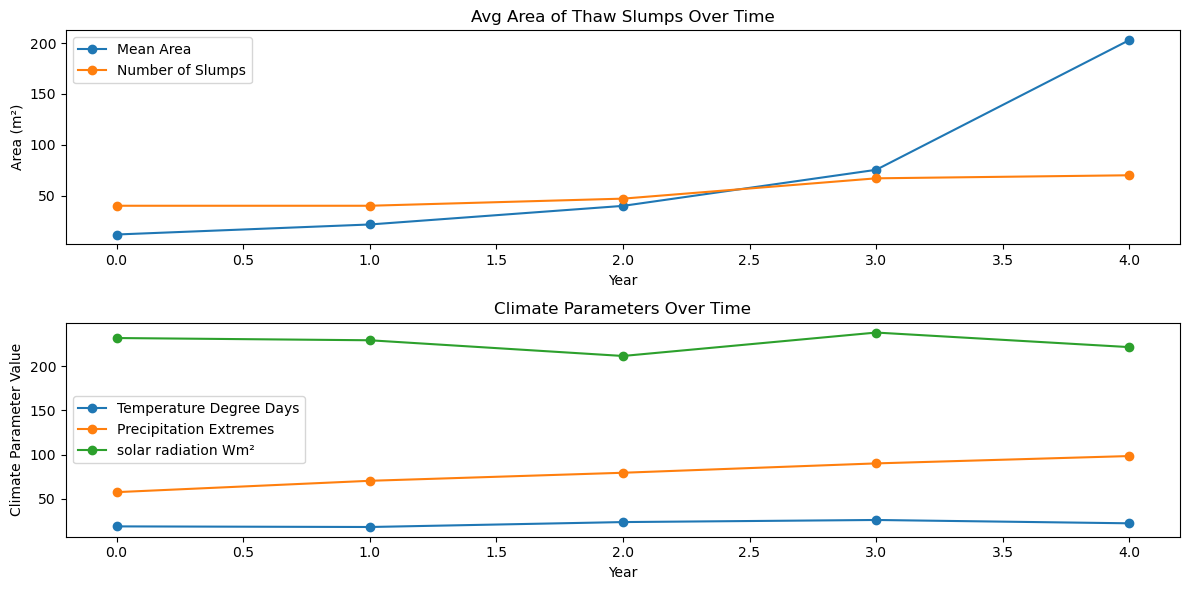

In [28]:
# first we need some data. Here we generate a time series of thaw slums and climate parameters. New slumps for example
# are initiated by rainfall, and existing slumps can fail due to hot summers. While in traditional state space model we look at newborns that change in survive and change in size,
# here we look at the area of thaw slumps, new ones are initiated and then persist. 

# This is a synthetic example, but it can be used to illustrate the concepts of Bayesian state space models.


import numpy as np
import pandas as pd

def simulate_thaw_slump_data(
    n_init = 40,
    n_years = 5,
    # ---- climate means and trends ---------------------------------
    temp_start = 18,     # °C·day in year 0
    temp_trend = 2,     # °C·day added each year
    prec_start = 60,     # mm   in year 0
    prec_trend = 10,     # mm   added each year
    # ---- survival (rare deaths) -----------------------------------
    base_surv_prob = 0.97,
    surv_temp_pen = -0.02,  # small penalty when temps are hot (z-score)
    # ---- growth vs precipitation -----------------------------------
    base_growth = 0.10,    # baseline proportional growth
    growth_prec_eff = 0.45, # boost per SD of precip
    # ---- initiations vs temperature ---------------------------------
    init_base_lambda = 2.5,    # expected new slumps at mean temp
    init_temp_eff = 10,        # +boost per SD of temp
    # ---- misc ------------------------------------------------------
    sigma_growth = 0.20,    # lognormal σ for growth noise
    seed = 42):
    rng = np.random.default_rng(seed)
    
    # Generate climate time series
    years = np.arange(n_years)
    clim = pd.DataFrame({
        "year":     years,
        "temp_dd":  temp_start + temp_trend * years + 
                    rng.normal(0, 2, n_years),
        "prec_ext": prec_start + prec_trend * years + 
                    rng.normal(0, 2, n_years),
        "rad":      rng.normal(210, 25, n_years)
    })
    
    # Calculate z-scores (trend still visible because early years are <0, late >0)
    clim_z = (clim[["temp_dd", "prec_ext", "rad"]] - 
             clim[["temp_dd", "prec_ext", "rad"]].mean()) / \
             clim[["temp_dd", "prec_ext", "rad"]].std()
    
    # Initialize tracking variables
    rec, alive_ids, next_id = [], [], 0
    
    # Initialize year 0 population
    init_sizes = rng.lognormal(mean=2.4, sigma=0.35, size=n_init)
    row0 = clim.loc[0]
    for area0 in init_sizes:
        rec.append(dict(id=next_id, area=area0, alive=1,
                       new_init=1, **row0))
        alive_ids.append(next_id)
        next_id += 1
    
    # Annual simulation loop
    for t in range(1, n_years):
        row, row_z = clim.loc[t], clim_z.loc[t]
        survivors = []
        
        # Survival and growth (only temperature affects survival, only precipitation affects growth)
        logit_surv = np.log(base_surv_prob / (1 - base_surv_prob))
        for ind in alive_ids:
            # Temperature-only survival probability
            p_surv = 1 / (1 + np.exp(-(logit_surv + 
                                    surv_temp_pen * row_z["temp_dd"])))
            last = next(r for r in rec if r["id"] == ind and r["year"] == t-1)
            
            if rng.random() < p_surv:  # survives
                # Precipitation-only growth
                g_mean = (base_growth + 
                         growth_prec_eff * row_z["prec_ext"])
                growth = rng.lognormal(mean=g_mean, sigma=sigma_growth)
                rec.append(dict(id=ind,
                              area=last["area"] * (1 + growth),
                              alive=1, new_init=0, **row))
                survivors.append(ind)
            else:  # dies (rare)
                rec.append(dict(id=ind, area=np.nan,
                              alive=0, new_init=0, **row))
        
        # Temperature-only initiation
        lam = init_base_lambda + init_temp_eff * row_z["temp_dd"]
        lam = max(lam, 0.1)  # guard against negatives
        n_new = rng.poisson(lam)
        
        for _ in range(n_new):
            rec.append(dict(id=next_id,
                          area=rng.lognormal(mean=2.2, sigma=0.30),
                          alive=1, new_init=1, **row))
            survivors.append(next_id)
            next_id += 1
        
        alive_ids = survivors
    
    return pd.DataFrame(rec), clim



df, clim = simulate_thaw_slump_data()
print(df.head())

# visualize the popluation and area as well as climate parameters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df.groupby("year")["area"].mean(), marker='o', label='Mean Area')
#plt.plot(df.groupby("year")["area"].sum(), marker='o', label='Total Area')
plt.plot(df.groupby("year")["alive"].sum(), marker='o', label='Number of Slumps')
plt.title('Avg Area of Thaw Slumps Over Time')
plt.xlabel('Year')
plt.ylabel('Area (m²)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(clim['year'], clim['temp_dd'], label='Temperature Degree Days', marker='o')
plt.plot(clim['year'], clim['prec_ext'], label='Precipitation Extremes', marker='o')
plt.plot(clim['year'], clim['rad'], label='solar radiation Wm²', marker='o')
plt.title('Climate Parameters Over Time')
plt.xlabel('Year')
plt.ylabel('Climate Parameter Value')
plt.legend()
plt.tight_layout()
plt.show()




In [29]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import arviz as az, pymc as pm
from scipy import stats as st
from IPython.display import display

In [30]:
T  = clim.shape[0]               # number of years
ids = df.id.unique();  I = len(ids)   # number of individuals

# 
area_mat      = np.full((I, T), np.nan)   # area of thaw slumps        
log_area_mat  = np.full((I, T), np.nan)   # we will use the log area in the model. This is a common transformation to stabilize variance
alive_mat     = np.zeros((I, T), dtype=int)  # alive status (1 = alive, 0 = dead)

id2idx = {i: k for k, i in enumerate(ids)}   # map id to index

# fill matrices with data
for _, r in df.iterrows():
    i, t = id2idx[r.id], int(r.year)
    area_mat[i, t]     = r.area                
    log_area_mat[i, t] = np.log1p(r.area)      
    alive_mat[i, t]    = r.alive

clim_raw = clim[["temp_dd", "prec_ext", "rad"]].values      # climate variables
clim_mat = (clim_raw - clim_raw.mean(0)) / clim_raw.std(0)  # z-score each variable


In [31]:
# build survival and growth data for the model, every row is a slump and every column is a year, 0,1 encoding alive or dead
def build_surv_grow():
    surv_size, surv_clim, surv_out, surv_idx = [], [], [], []   # add idx for id
    grow_prev, grow_clim, grow_next          = [], [], [] 
    for t in range(T-1):
        for i in range(I):
            if alive_mat[i, t]:
                surv_size.append(log_area_mat[i, t])            # use log area for survival matrix
                surv_clim.append(clim_mat[t])
                surv_out.append(alive_mat[i, t+1])
                surv_idx.append(i)                              

                if alive_mat[i, t+1]:
                    grow_prev.append(log_area_mat[i, t])
                    grow_clim.append(clim_mat[t])
                    grow_next.append(log_area_mat[i, t+1])

    return map(np.asarray,
               (surv_size, surv_clim, surv_out, surv_idx,
                grow_prev, grow_clim, grow_next))

(surv_size, surv_clim, surv_out, surv_idx,
 grow_prev, grow_clim, grow_next) = build_surv_grow()

# births:  z-score N_prev  +  climate already z-scored
N_t        = alive_mat.sum(axis=0)
birth_cnts = (df[df.new_init == 1]           
                .groupby("year").size()
                .reindex(range(T), fill_value=0)
                .values)

birth_clim = clim_mat[1:]                    
N_prev     = (N_t[:-1] - N_t[:-1].mean()) / N_t[:-1].std()

ice_area   = 100                                            # ice area in m², used for scaling births
ice_offset = np.log(ice_area) * np.ones_like(birth_cnts[1:])# log area offset for births, to stabilize the model

In [32]:
# configure the PyMC model. Here we use a Bayesian state space model to estimate
# the parameters of the survival, growth, and initiation processes.
with pm.Model() as pop_model:

    # ---------------- data holders ----------------
    # MutableData allows us to use data that is not fixed, but can be updated
    # during the model fitting process. This is useful for time series data.

    S_size   = pm.MutableData("S_area", surv_size)
    S_clim   = pm.MutableData("S_clim", surv_clim)
    S_out    = pm.MutableData("S_out",  surv_out)
    S_idx    = pm.MutableData("S_idx",  surv_idx)            

    G_prev   = pm.MutableData("G_prev", grow_prev)
    G_clim   = pm.MutableData("G_clim", grow_clim)
    G_next   = pm.MutableData("G_next", grow_next)

    B_cnt    = pm.MutableData("B_cnt",  birth_cnts[1:])      # new slumps
    B_clim   = pm.MutableData("B_clim", birth_clim)
    N_prev_d = pm.MutableData("N_prev", N_prev)
    B_off    = pm.MutableData("B_off",  ice_offset)          

    # ---------------- persistence (logistic) --------------------
    # Here we model the probability of survival of existing slumps based on their
    # size and climate conditions. The logistic regression is used to model the
    # probability of survival, which is a common approach in survival analysis.
    # The coefficients are estimated using a normal prior distribution.

    alpha_surv_pop = pm.Normal("alpha_surv_pop", 0, 1.5)           # the population-level intercept for survival. This is the baseline survival probability when all predictors are zero.
    sigma_surv     = pm.HalfNormal("sigma_surv", sigma=0.5)  # scale for individual intercepts, using a half Student-t distribution to allow for heavy-tailed distributions
    alpha_surv_offset = pm.Normal("alpha_surv_offset", 0, 1, shape=I)
    alpha_surv_i   = pm.Deterministic("alpha_surv_i", alpha_surv_pop + alpha_surv_offset * sigma_surv)  # individual intercepts for survival, allowing each individual to have its own baseline survival probability

    beta_size  = pm.Normal("beta_size", 0, 1)

    # spike-and-slab for the three climate slopes (gives inclusion stats, how important is each climate variable)
    # The spike-and-slab prior is a Bayesian variable selection technique that allows us to
    # include or exclude climate variables in the model based on their importance.
    pi_surv   = pm.Beta("pi_surv", 1, 1, shape=3)
    z_surv    = pm.Bernoulli("z_surv", p=pi_surv, shape=3)
    beta_raw  = pm.Normal("beta_raw", 0, 0.3, shape=3)      
    beta_clim = pm.Deterministic("beta_clim", z_surv * beta_raw)

    # The logit link function is used to model the probability of survival.
    # The logit function transforms the linear combination of predictors into a probability.
    logit_p = (alpha_surv_i[S_idx] + beta_size*S_size
               + pm.math.sum(S_clim*beta_clim, axis=1))

    # The Bernoulli distribution is used to model the binary outcome of survival (1) or death (0).
    # The observed data is the survival status of the slumps. The model estimates the probability
    # of survival based on the size and climate conditions.
    pm.Bernoulli("persistence", logit_p=logit_p, observed=S_out)

    # ---------------- expansion (Student-t) ---------------------
    # Here we define priors for the parameters of the growth model.
    # The growth model predicts the size of slumps in the next year based on their current size
    # and climate conditions. We use a Student-t distribution to model the growth, which is robust
    # to outliers and allows for heavy-tailed distributions. The Student-t distribution is
    # parameterized by its mean, scale (standard deviation), and degrees of freedom (nu).

    alpha_grow = pm.Normal("alpha_grow", 0, 1) # population-level intercept for growth

    # rho is the scaling factor for the previous year's size, allowing for growth based on the previous year's area.
    rho        = pm.TruncatedNormal("rho", mu=1, sigma=0.5, lower=0, upper=2) # 

    
    pi_grow    = pm.Beta("pi_grow", 1, 1, shape=3)
    z_grow     = pm.Bernoulli("z_grow", p=pi_grow, shape=3)
    gamma_raw  = pm.Normal("gamma_raw", 0, 0.3, shape=3)      
    gamma_clim = pm.Deterministic("gamma_clim", z_grow * gamma_raw)

    sigma_grow = pm.HalfNormal("sigma_grow", sigma=0.5)  
    nu_grow    = pm.Exponential("nu_grow", 1/15) + 2             

    mu_grow = alpha_grow + rho*G_prev + pm.math.sum(G_clim*gamma_clim, axis=1)
    pm.StudentT("expansion", mu=mu_grow, sigma=sigma_grow, nu=nu_grow,
                observed=G_next)

    # -------------- new-slump initiations  ----------------------
    # Here we model the number of new slumps initiated each year based on the previous year's
    # population size and climate conditions. We use a zero-inflated Poisson distribution to
    # model the count of new slumps. The zero-inflated Poisson distribution allows for excess
    # zeros in the data, which is common in count data where many years have no new slumps.
    alpha_init  = pm.Normal("alpha_init", 0, 1)
    phi         = pm.Normal("phi", 0, 1)

    # spike-and-slab for initiation covariates
    pi_init   = pm.Beta("pi_init", 1, 1, shape=3)
    z_init    = pm.Bernoulli("z_init", p=pi_init, shape=3)
    delta_raw = pm.Normal("delta_raw", 0, 0.3, shape=3)         
    delta_clim= pm.Deterministic("delta_clim", z_init * delta_raw)

    # The log-linear model for the expected number of new slumps is defined.
    log_lambda  = (alpha_init + phi*N_prev_d
                   + pm.math.sum(B_clim*delta_clim, axis=1)
                   + B_off)                                      

    lambda_safe = pm.math.exp(log_lambda)

    # probability of a structural zero (year with no new slumps)
    psi = pm.Beta("psi", 2, 2)                     # weakly centred at 0.5

    # The ZeroInflatedPoisson distribution is used to model the count of new slumps.
    # It combines a Bernoulli distribution for the zero-inflation and a Poisson distribution for the count data.
    pm.ZeroInflatedPoisson("new_slumps",
                           psi=psi,
                           mu=lambda_safe,
                           observed=B_cnt)

    # -------------- inference (NUTS) ----------------------------------------
    
    trace = pm.sample(4000, tune=3000,
                      chains=4, 
                      target_accept=0.99,
                      random_seed=2025,
                      progressbar=True)


c:\Users\castad001\AppData\Local\miniconda3\miniconda\envs\plotting\Lib\site-packages\pymc\data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [alpha_surv_pop, sigma_surv, alpha_surv_offset, beta_size, pi_surv, beta_raw, alpha_grow, rho, pi_grow, gamma_raw, sigma_grow, nu_grow, alpha_init, phi, pi_init, delta_raw, psi]
>BinaryGibbsMetropolis: [z_surv, z_grow, z_init]


Output()

Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 1232 seconds.
c:\Users\castad001\AppData\Local\miniconda3\miniconda\envs\plotting\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [33]:
# next we will evaluate the model fit using posterior predictive checks
# The posterior predictive checks will help us assess how well the model predicts the observed data.

# posterior-predictive draws of the 'expansion' node 
# (the continuous outcome of the growth process)
with pop_model:
    ppc_growth = pm.sample_posterior_predictive(
        trace,
        var_names=["expansion"],         # just the continuous outcome
        progressbar=True,
        return_inferencedata=False,
    )

    #az.plot_pair(trace, var_names=["sigma_surv", "alpha_surv_pop"], divergences=True,kind="kde")



y_obs  = grow_next                       # observed log-areas at t+1
y_pred = ppc_growth["expansion"]         # shape (draw, obs)

# 1) Residual SD 
y_pred_mean = y_pred.mean(axis=0)
residuals   = y_obs - y_pred_mean
resid_sd    = residuals.std(ddof=1)

# 2) Prediction SD 
pred_sd = y_pred.std(ddof=1)             # SD across draws *and* obs

# 3) Bayesian R²  (Gelman et al. 2019) 
r2 = 1 - (residuals.var(ddof=1) / y_obs.var(ddof=1))

# 4) Posterior-predictive log score (replaces Harvey GF for heavy tails) ----
log_score = np.mean(st.t.logpdf(residuals,
                                df=float(trace.posterior["nu_grow"].mean()),
                                loc=0,
                                scale=float(trace.posterior["sigma_grow"].mean())))

# -------- assemble a neat one-row DataFrame like the blog’s table ----------
model_summary = pd.DataFrame(
    [[resid_sd, pred_sd, r2, log_score]],
    columns=["Residual SD", "Prediction SD", "R²", "Posterior predictive log-score"]
).round(3)

# from this we get the residual SD, prediction SD, Bayesian R², and posterior predictive log-score. 
# The residual SD indicates how well the model captures the variability in the growth of thaw slumps (better is lower), 
# while the prediction SD shows the uncertainty in the predictions (better is lower). 
# The Bayesian R² provides a measure of how much variance in the data is explained by the model (better is higher), 
# and the posterior predictive log-score gives an indication of the model's predictive performance (better is higher).


Sampling: [expansion]


Output()

In [34]:
# Now we can summarize the posterior draws of the model parameters, including the inclusion statistics for the climate variables.
# The inclusion statistics will help us understand the importance of each climate variable in the model.
# we also compute the posterior inclusion probabilities and Bayes factors for the climate variables.
# The Bayes factors indicate how much more likely the data is under the model with the climate variable included compared to the model without it.


def inclusion_stats(z, pi=0.5):
    """Posterior inclusion probability & BF from spike-and-slab indicator."""
    post = z.mean()
    bf   = (post / (1 - post)) / (pi / (1 - pi))
    return pi, post, bf


rows, zmap = [], {
    "beta_clim":  "z_surv",
    "gamma_clim": "z_grow",
    "delta_clim": "z_init"
}


for par in ["alpha_surv_pop", "beta_size"]:
    draws = trace.posterior[par].values.ravel()
    try:                                         # try ArviZ first
        bf = float(az.bayes_factor(draws, point=0)["BF"])
    except Exception:
        bf = np.inf
    rows.append([par, 1, 1, bf,
                 draws.mean(), draws.std(), *az.hdi(draws, 0.95)])


for coef, zname in zmap.items():
    coeff  = trace.posterior[coef].values       # (chain, draw, 3)
    z_draw = trace.posterior[zname].values
    for j in range(coeff.shape[2]):
        d = coeff[..., j].ravel()
        prior, post, bf_sd = inclusion_stats(z_draw[..., j].ravel())
        try:
            bf_az = float(az.bayes_factor(d, point=0)["BF"])
            bf = bf_az if np.isfinite(bf_az) else bf_sd
        except Exception:
            bf = bf_sd
        rows.append([f"{coef}[{j}]", prior, post, bf,
                     d.mean(), d.std(), *az.hdi(d, 0.95)])


for par in ["alpha_grow", "rho", "alpha_init", "phi",
            "sigma_grow", "psi", "nu_grow", "sigma_surv"]:
    d = trace.posterior[par].values.ravel()
    try:
        bf = float(az.bayes_factor(d, point=0)["BF"])
    except Exception:
        bf = np.inf
    rows.append([par, 1, 1, bf,
                 d.mean(), d.std(), *az.hdi(d, 0.95)])

posterior_tbl = (
    pd.DataFrame(rows, columns=[
        "Coefficient", "P(incl)", "P(incl|data)", "BF_incl",
        "Mean", "SD", "HDI-5%", "HDI-95%"
    ])
    .round(3)
    .set_index("Coefficient")
)

display(posterior_tbl)




C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\3933528985.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  bf   = (post / (1 - post)) / (pi / (1 - pi))


,P(incl),P(incl|data),BF_incl,Mean,SD,HDI-5%,HDI-95%
Coefficient,,,,,,,
alpha_surv_pop,1.0,1.000,inf,2.709,1.071,0.659,4.808
beta_size,1.0,1.000,inf,0.359,0.341,-0.286,1.045
beta_clim[0],0.5,0.487,0.951,-0.062,0.185,-0.524,0.298
beta_clim[1],0.5,0.539,1.167,-0.102,0.220,-0.648,0.264
beta_clim[2],0.5,0.515,1.062,-0.089,0.199,-0.588,0.244
gamma_clim[0],0.5,0.232,0.302,0.007,0.016,-0.000,0.048
gamma_clim[1],0.5,1.000,inf,0.185,0.022,0.134,0.220
gamma_clim[2],0.5,0.112,0.126,-0.002,0.005,-0.015,0.000
delta_clim[0],0.5,0.494,0.977,0.003,0.209,-0.505,0.474


### Parameter explanations

,Explanation
Parameter,
alpha_surv_pop,Population intercept (survival log-odds)
beta_size,Size slope on survival (log-area)
beta_clim[0],Temp DD slope on survival
beta_clim[1],Extreme precip slope on survival
beta_clim[2],Radiation slope on survival
alpha_grow,Intercept: baseline growth (log-area)
rho,Autoregressive size effect (log-area)
gamma_clim[0],Temp DD slope on growth
gamma_clim[1],Extreme precip slope on growth


### Posterior-inclusion & coefficient summary

,P(incl),P(incl|data),BF_incl,Mean,SD,HDI-5%,HDI-95%
Coefficient,,,,,,,
alpha_surv_pop,1.0,1.000,inf,2.709,1.071,0.659,4.808
beta_size,1.0,1.000,inf,0.359,0.341,-0.286,1.045
beta_clim[0],0.5,0.487,0.951,-0.062,0.185,-0.524,0.298
beta_clim[1],0.5,0.539,1.167,-0.102,0.220,-0.648,0.264
beta_clim[2],0.5,0.515,1.062,-0.089,0.199,-0.588,0.244
gamma_clim[0],0.5,0.232,0.302,0.007,0.016,-0.000,0.048
gamma_clim[1],0.5,1.000,inf,0.185,0.022,0.134,0.220
gamma_clim[2],0.5,0.112,0.126,-0.002,0.005,-0.015,0.000
delta_clim[0],0.5,0.494,0.977,0.003,0.209,-0.505,0.474


### Model evaluation (growth component)

,Residual SD,Prediction SD,R²,Posterior predictive log-score
0,0.133,1.035,0.984,0.587


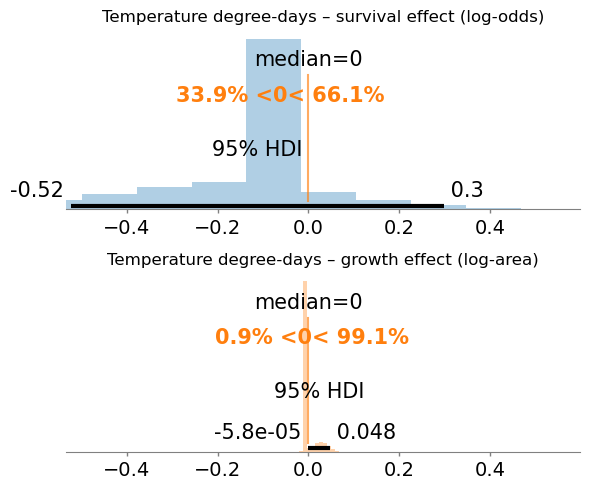

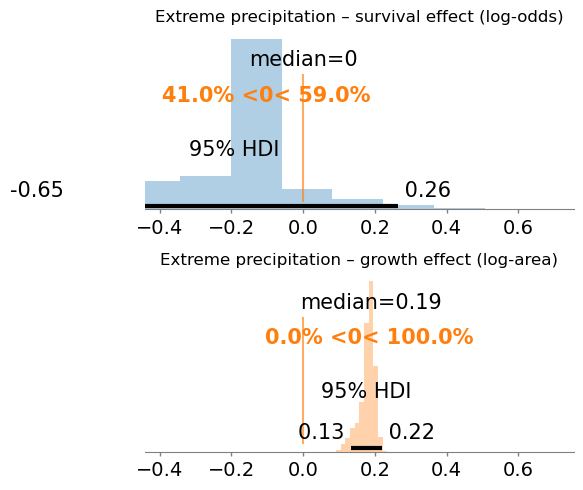

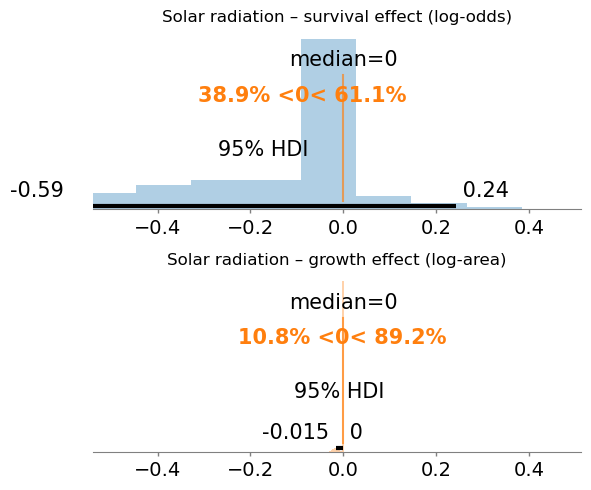

### Plain-language summaries

* **Temperature degree-days** — a +1 SD increase multiplies survival odds by ≈ 1.00× (95 % CI 0.59–1.35) and changes next-year slump area by ≈ 0.0% (95 % CI -0.0%–4.9%).

* **Extreme precipitation** — a +1 SD increase multiplies survival odds by ≈ 1.00× (95 % CI 0.52–1.30) and changes next-year slump area by ≈ 20.9% (95 % CI 14.3%–24.6%).

* **Solar radiation** — a +1 SD increase multiplies survival odds by ≈ 1.00× (95 % CI 0.56–1.28) and changes next-year slump area by ≈ 0.0% (95 % CI -1.5%–0.0%).

In [35]:
# Now we can visualize the results of the model, including the posterior distributions of the parameters,
# the inclusion statistics for the climate variables, and the posterior predictive checks.
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pandas as pd

# to not get lost in the parameter names, we can create a list of tuples with parameter names and their explanations
# and display it as a Markdown table.


# ---------- parameter explanations (unchanged) ------------------------------
param_expl = [
("alpha_surv_pop", "Population intercept (survival log-odds)"),
("beta_size",      "Size slope on survival (log-area)"),
("beta_clim[0]",   "Temp DD slope on survival"),
("beta_clim[1]",   "Extreme precip slope on survival"),
("beta_clim[2]",   "Radiation slope on survival"),
("alpha_grow",     "Intercept: baseline growth (log-area)"),
("rho",            "Autoregressive size effect (log-area)"),
("gamma_clim[0]",  "Temp DD slope on growth"),
("gamma_clim[1]",  "Extreme precip slope on growth"),
("gamma_clim[2]",  "Radiation slope on growth"),
("sigma_grow",     "Residual SD (growth, log-scale)"),
("alpha_init",     "Intercept: baseline initiation"),
("phi",            "Density feedback on initiations"),
("delta_clim[0]",  "Temp DD slope on initiation"),
("delta_clim[1]",  "Extreme precip slope on initiation"),
("delta_clim[2]",  "Radiation slope on initiation"),
("psi",            "Zero-inflation probability"),
("nu_grow",        "Student-t degrees-of-freedom"),
("sigma_surv",     "SD of random intercepts (survival)")
]
param_tbl = (pd.DataFrame(param_expl, columns=["Parameter", "Explanation"])
             .set_index("Parameter"))

# ---------- display everything ---------------------------------------------
display(Markdown("### Parameter explanations"))
display(param_tbl)

display(Markdown("### Posterior-inclusion & coefficient summary"))
display(posterior_tbl)

display(Markdown("### Model evaluation (growth component)"))
display(model_summary)

# ---------- 2. climate-covariate effect plots (az.plot_posterior) ----------
cov_names = ["Temperature degree-days",
             "Extreme precipitation",
             "Solar radiation"]

interpretations = []

for j, cov in enumerate(cov_names):
    # grab draws
    beta  = trace.posterior["beta_clim"].values[..., j].ravel()   # survival
    gamma = trace.posterior["gamma_clim"].values[..., j].ravel()  # growth

    # -- figure: two stacked posteriors -------------------------------------
    fig, ax = plt.subplots(nrows=2, figsize=(6, 5), sharex=True)
    az.plot_posterior(beta,  ax=ax[0], hdi_prob=0.95,
                      ref_val=0, color="C0",
                      kind="hist", point_estimate="median")
    ax[0].set_title(f"{cov} – survival effect (log-odds)")

    az.plot_posterior(gamma, ax=ax[1], hdi_prob=0.95,
                      ref_val=0, color="C1",
                      kind="hist", point_estimate="median")
    ax[1].set_title(f"{cov} – growth effect (log-area)")
    plt.tight_layout(); plt.show()

    # it can be hard to interpret the tables directly, so we have some plain-language summaries
    odds_med = np.exp(np.median(beta))
    odds_low, odds_hi = np.exp(az.hdi(beta, 0.95))

    pct_med  = (np.exp(np.median(gamma)) - 1) * 100
    pct_low, pct_hi = (np.exp(az.hdi(gamma, 0.95)) - 1) * 100

    interpretations.append(
        f"* **{cov}** — a +1 SD increase multiplies survival odds by "
        f"≈ {odds_med:.2f}× (95 % CI {odds_low:.2f}–{odds_hi:.2f}) and changes "
        f"next-year slump area by ≈ {pct_med:.1f}% "
        f"(95 % CI {pct_low:.1f}%–{pct_hi:.1f}%)."
    )

#
display(Markdown("### Plain-language summaries"))
for line in interpretations:
    display(Markdown(line))


C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\2686340124.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]


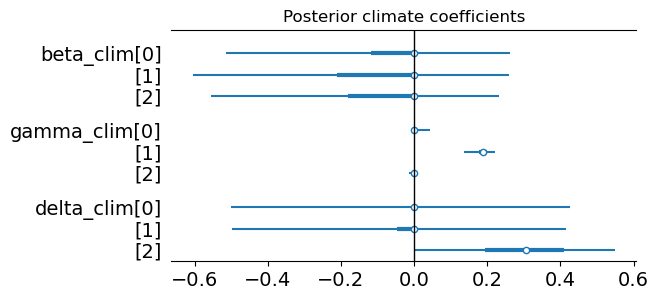

In [36]:
# We can also visualise the impacts of climate on the survival, growth, and initiation of thaw slumps. 
clim_labels = ["temperature degree-days", "precipitation extremes", "radiation"]
n_draws     = trace.posterior.dims["draw"] * trace.posterior.dims["chain"]

# We can  plot the posterior distributions of the climate coefficients to see how they impact the survival, growth, and initiation of thaw slumps.
az.plot_forest(
    trace,
    var_names=[r"beta_clim", r"gamma_clim", r"delta_clim"],
    combined=True,  # merge chains
    figsize=(6, 3),
)
plt.axvline(0, color="k", lw=1)
plt.title("Posterior climate coefficients"); plt.show()



C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)
C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\1202129413.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)


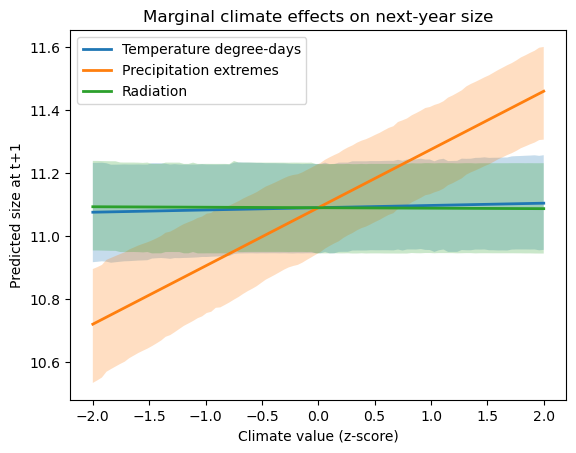

In [37]:
# Maybe we wamt to see the marginal effects of each climate variable on the next year's size of thaw slumps.
alpha  = trace.posterior["alpha_grow"].stack(samples=("chain", "draw")).values       # (n_draws,)
rho  = trace.posterior["rho"].stack(samples=("chain", "draw")).values           # (n_draws,)
gamma  = trace.posterior["gamma_clim"].stack(samples=("chain", "draw")).values      # (3, n_draws)

s0 = 10                                 # reference current size
grid = np.linspace(-2, 2, 100)          # ±2 SD for each climate var

for j, lab in enumerate(clim_labels):
    X = np.zeros((grid.size, 3))
    X[:, j] = grid                      # vary ONE covariate, others kept at 0
    mu = alpha[None, :] + rho[None, :] * s0 + (X @ gamma)      # (grid, draws)

    mu_mean = mu.mean(1)
    mu_hdi  = az.hdi(mu.T, 0.94)        # (grid, 2)

    plt.fill_between(grid, mu_hdi[:, 0], mu_hdi[:, 1], alpha=0.25)
    plt.plot(grid, mu_mean, lw=2, label=lab.capitalize())

plt.xlabel("Climate value (z-score)")
plt.ylabel("Predicted size at t+1")
plt.title("Marginal climate effects on next-year size")
plt.legend(); plt.show()





C:\Users\castad001\AppData\Local\Temp\ipykernel_24276\3975446578.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  init_hdi   = az.hdi(init_preds.T, 0.94)


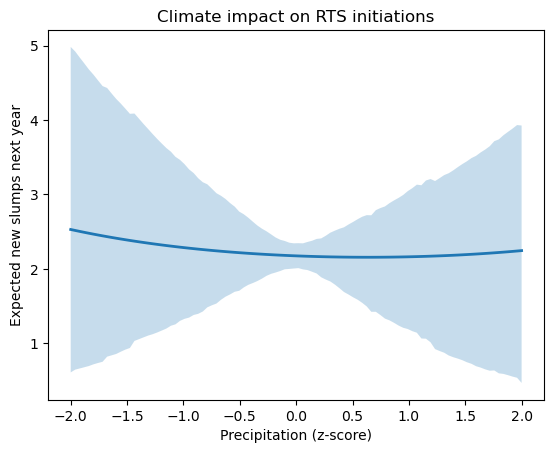

In [38]:
#The elasticities of the growth model can be visualised to see how sensitive the growth is to changes in climate variables.
alpha_i = trace.posterior["alpha_grow"].stack(samples=("chain","draw")).values
phi     = trace.posterior["phi"].stack(samples=("chain","draw")).values
delta   = trace.posterior["delta_clim"].stack(samples=("chain","draw")).values

N_mean  = N_prev.mean()
prec_grid = grid
init_preds = []

for prec in prec_grid:
    X = np.array([0, prec, 0])            # vary precipitation only
    loglam = alpha_i + phi * N_mean + (delta.T @ X)
    init_preds.append(np.exp(loglam))

init_preds = np.array(init_preds)
init_mean  = init_preds.mean(1)
init_hdi   = az.hdi(init_preds.T, 0.94)

plt.fill_between(prec_grid, init_hdi[:,0], init_hdi[:,1], alpha=.25)
plt.plot(prec_grid, init_mean, lw=2)
plt.xlabel("Precipitation (z-score)")
plt.ylabel("Expected new slumps next year")
plt.title("Climate impact on RTS initiations"); plt.show()

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
n_draws = 500  # you can increase this for more precision
T = len(birth_cnts)  # number of years
N_sim = np.zeros((n_draws, T))
A_sim = np.zeros((n_draws, T))

# Start from year 0
N_sim[:, 0] = N_prev[:, 0]  # or set to initial population
A_sim[:, 0] = np.exp(grow_prev[:, 0])  # initial area in normal scale

# Draw posterior samples
alpha_grow = trace.posterior["alpha_grow"].stack(draw=("chain", "draw")).values[:n_draws]
rho        = trace.posterior["rho"].stack(draw=("chain", "draw")).values[:n_draws]
sigma_grow = trace.posterior["sigma_grow"].stack(draw=("chain", "draw")).values[:n_draws]

# Loop through time
for t in range(1, T):
    # Estimate number of slumps
    N_sim[:, t] = N_sim[:, t-1] * S_out[:, t-1] + birth_cnts[t]  # survival + new
    # Estimate area (lognormal approximation)
    logA = alpha_grow + rho * np.log(A_sim[:, t-1] + 1e-6)  # prevent log(0)
    A_sim[:, t] = np.exp(logA + np.random.normal(0, sigma_grow))  # add residual noise

# Compute posterior summaries
N_median = np.median(N_sim, axis=0)
N_hdi = az.hdi(N_sim, hdi_prob=0.95)

A_median = np.median(A_sim, axis=0)
A_hdi = az.hdi(A_sim, hdi_prob=0.95)

# ------------------ Plot ------------------
years = np.arange(T)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Population size
ax[0].plot(years, N_median, label="Median", color="C0")
ax[0].fill_between(years, N_hdi[:, 0], N_hdi[:, 1], alpha=0.3, color="C0")
ax[0].set_ylabel("Number of slumps")
ax[0].set_title("Posterior trajectory: Slump count")

# Total area
ax[1].plot(years, A_median, label="Median", color="C1")
ax[1].fill_between(years, A_hdi[:, 0], A_hdi[:, 1], alpha=0.3, color="C1")
ax[1].set_ylabel("Total area")
ax[1].set_title("Posterior trajectory: Total area")
ax[1].set_xlabel("Year")

plt.tight_layout()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed